# <left>Synthetic Points from Raster tool (*SPR*)

## Howdy! 

This notebook assumes the ipynb resides directly in the “main directory” with a ‘_input’ folder housing the input files. We will create and use an ‘output’ folder for output files.

***

"Synthetic Points from Raster $(SPR)$" will take an input raster and create a single point from each cell with the cell value, and output a new TXT, which can then be read into software (such as Quick Terrain Modeler) as XYZ (ASCII) and exported as LAZ / LAS. 
<br><br>
This is useful for gap-filling from a DEM or generating a "top of canopy LAS" from a CHM.
<br><br>
If it is necessary to replace negative Z values with 0, the last cell will write a new TXT. 


***
### 1.0 - Setup Notebook

#### Import the necessary modules 

In [1]:
import os 
import re
import arcpy 
import pandas as pd
from pathlib import Path

#### Set workspace 
Creates an "output" folder and sets it as the current working directory so all outputs below don't need a folder specified. 
This also creates other folders such as "figures". 

In [2]:
output = './output/'
if not os.path.exists(output):
    os.makedirs(output)

path = os.getcwd() + '\\output'
os.chdir(path)

arcpy.env.workspace = path
arcpy.env.overwriteOutput = True

print(os.getcwd())

c:\Temp\sample_code\00_LAS_synpts_raster\output


### 2.0 - Analysis


If using the "_input" folder for model inputs, this cell lists the files and specific extentions in the folder. 

In [18]:
in_dir = '../_input/'

ext = '.tif'
for file in os.listdir(in_dir):
    if file.endswith(ext):
        print(ext + ' files in "_input" folder: ' + file)

.tif files in "_input" folder: 50cm CHM test.tif


Specifies the input raster from "_input" folder or from absolute path. 

In [19]:
inRaster = in_dir + '50cm CHM test.tif'
# inRaster = r"C:\Temp\sample_code\00_LAS_synpts_raster\_input\50cm CHM test.tif"

Display the raster. 

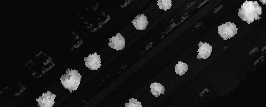

In [20]:
arcpy.sa.Render(inRaster, colormap='gray')

Parse path to extract the file basename with extension and replace illegal characters. 

In [21]:
name0 = Path(inRaster).stem
name1 = re.sub('[^0-9a-zA-Z]+', '_', name0)
if name1[0].isdigit():
    name1 = "_" + name1
print('old name: ' + name0)
print('new name: ' + name1)

old name: 50cm CHM test
new name: _50cm_CHM_test


Create a point from each cell with the cell value. 

In [22]:
name_pts = name1 + '_points.shp'
rtp = arcpy.conversion.RasterToPoint(inRaster, name_pts, 'VALUE')

Creates "X" and "Y" fields and calculates geometry.

In [23]:
temp1 = arcpy.management.CalculateGeometryAttributes(rtp, geometry_property=[['X', 'POINT_X'], ['Y', 'POINT_Y']])

Creates "Z" field and calculates from "grid_code". 

In [24]:
temp2 = arcpy.management.CalculateField(rtp, 'Z', '!grid_code!', field_type = 'DOUBLE')

Deletes unnecessary fields and lists remaining fields. 

In [25]:
arcpy.management.DeleteField(name_pts, ['grid_code', 'pointid'])

fields = arcpy.ListFields(name_pts)

for field in fields:
    print(f"{field.name} has a type of {field.type} with a length of {field.length}")


FID has a type of OID with a length of 4
Shape has a type of Geometry with a length of 0
X has a type of Double with a length of 19
Y has a type of Double with a length of 19
Z has a type of Double with a length of 19


### 3.0 - Export TXT and review the table.

In [26]:
name_table = name1 + '_points_table.txt'
arcpy.conversion.ExportTable(name_pts, name_table)
tab = pd.read_csv(name_table)
tab.head()

,X,Y,Z
0,754159.457794,3.389055e+06,-0.000047
1,754159.957793,3.389055e+06,-0.000047
2,754160.457793,3.389055e+06,-0.000047
3,754160.957792,3.389055e+06,-0.000047
4,754161.457791,3.389055e+06,-0.000047


Check min and max Z values. 

In [27]:
print('min: ', f'{min(tab.loc[:,"Z"]):.3f}')
print('max: ', f'{max(tab.loc[:,"Z"]):.3f}')

min:  -0.334
max:  7.878


### 3.1 - Convert negative Z values to 0 and export new TXT

If you need to replace negative Z values, use the code below.

The `lidR` treetops script does not like negative values, so we will replace with 0 and write a new TXT. 

In [29]:
tab.loc[tab['Z']<0, 'Z'] = 0
print('min: ', f'{min(tab.loc[:,"Z"]):.3f}')
print('max: ', f'{max(tab.loc[:,"Z"]):.3f}')
tab.to_csv(name1 + '_points_table_0Z.txt', index=False)

min:  0.000
max:  7.878


This TXT can be read into software (such as Quick Terrain Modeler) as XYZ (ASCII) and exported as LAZ / LAS. 

## Contact 

**Justinn J. Jones ’24, GISP**

Graduate Research Assistant / FAA sUAS RP

LASERS Lab / WFES 360

Department of Ecology & Conservation Biology

College of Agriculture & Life Sciences

justinn.j.jones@tamu.edu

**TEXAS A&M UNIVERSITY**